In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data_new .csv")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = data['Class Name'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(list(data['Stemmed_Review_str']), y, 
                                                   test_size=0.2, 
                                                   random_state = 0, 
                                                   #stratify = y,
                                                   shuffle=True)

In [ ]:
max_length = max(data['Stemmed_Review_str'].apply(lambda row : len(row)))
max_length

396

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_length)
vectorizer.adapt(X_train)

In [ ]:
vectorizer.get_vocabulary()[:6]

['', '[UNK]', 'lov', 'dress', 'fit', 'siz']

In [ ]:
import os 

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/drive/MyDrive/glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Préparation de la matrix d'embedding

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4785 words (2256 misses)


In [ ]:

from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
genres = data['Class Name'].unique()

In [ ]:
from tensorflow.keras import layers, Input, Model

int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(embedded_sequences)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(5)(x)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_nlp = layers.Dense(len(genres), activation="softmax")(x)
                          
model_nlp = Model(int_sequences_input, output_nlp)
model_nlp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         2112900   
                                                                 
 batch_normalization (BatchN  (None, None, 300)        1200      
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                           

In [ ]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
model_nlp.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
history = model_nlp.fit(x_train, y_train,
                        batch_size=32, 
                        #callbacks=callback, 
                        epochs=25,
                        validation_split=0.2,
                        verbose=2)

Epoch 1/25
394/394 - 185s - loss: 2.1478 - acc: 0.3621 - val_loss: 1.7812 - val_acc: 0.4825 - 185s/epoch - 469ms/step
Epoch 2/25
394/394 - 182s - loss: 1.7172 - acc: 0.4684 - val_loss: 1.5269 - val_acc: 0.5216 - 182s/epoch - 462ms/step
Epoch 3/25
394/394 - 186s - loss: 1.5397 - acc: 0.5124 - val_loss: 1.4554 - val_acc: 0.5448 - 186s/epoch - 472ms/step
Epoch 4/25
394/394 - 183s - loss: 1.4238 - acc: 0.5454 - val_loss: 1.6456 - val_acc: 0.5375 - 183s/epoch - 464ms/step
Epoch 5/25
394/394 - 183s - loss: 1.3320 - acc: 0.5664 - val_loss: 2.1907 - val_acc: 0.4847 - 183s/epoch - 465ms/step
Epoch 6/25
394/394 - 182s - loss: 1.2637 - acc: 0.5844 - val_loss: 3.2201 - val_acc: 0.4711 - 182s/epoch - 463ms/step
Epoch 7/25
394/394 - 183s - loss: 1.1983 - acc: 0.5986 - val_loss: 3.1167 - val_acc: 0.4774 - 183s/epoch - 464ms/step
Epoch 8/25
394/394 - 182s - loss: 1.1519 - acc: 0.6108 - val_loss: 3.2703 - val_acc: 0.5016 - 182s/epoch - 462ms/step
Epoch 9/25
394/394 - 182s - loss: 1.1151 - acc: 0.6181 -

In [ ]:
def PlotModel(history=history, metric='acc', metric_val='val_acc', loss='loss',
              val_loss='val_loss'):  
  ### Graphique des résultats de l'entraînement ###
  plt.plot(history.history[metric])
  plt.plot(history.history[metric_val])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history[loss])
  plt.plot(history.history[val_loss])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

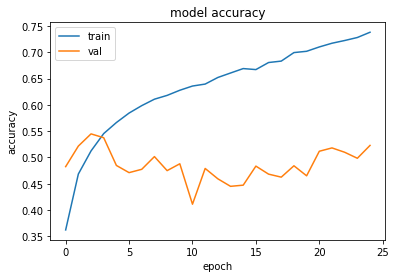

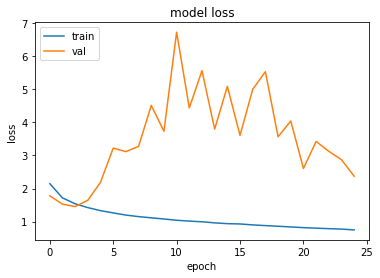

In [ ]:
PlotModel(history=history)

In [ ]:
y = data['Department Name'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(list(data['Stemmed_Review_str']), y, 
                                                   test_size=0.2, 
                                                   random_state = 0, 
                                                   #stratify = y,
                                                   shuffle=True)

In [ ]:
max_length = max(data['Stemmed_Review_str'].apply(lambda row : len(row)))
max_length

396

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_length)
vectorizer.adapt(X_train)

In [ ]:
vectorizer.get_vocabulary()[:6]

['', '[UNK]', 'lov', 'dress', 'fit', 'siz']

In [ ]:
import os 

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/drive/MyDrive/glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4785 words (2256 misses)


In [ ]:

from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
genres = data['Department Name'].unique()

In [ ]:
from tensorflow.keras import layers, Input, Model

int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(embedded_sequences)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(5)(x)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_nlp = layers.Dense(len(genres), activation="softmax")(x)
                          
model_nlp = Model(int_sequences_input, output_nlp)
model_nlp.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         2112900   
                                                                 
 batch_normalization_2 (Batc  (None, None, 300)        1200      
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         192128    
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

In [ ]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
model_nlp.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
history = model_nlp.fit(x_train, y_train,
                        batch_size=32, 
                        #callbacks=callback, 
                        epochs=25,
                        validation_split=0.2,
                        verbose=2)

Epoch 1/25
394/394 - 169s - loss: 1.1577 - acc: 0.5978 - val_loss: 0.8786 - val_acc: 0.7072 - 169s/epoch - 429ms/step
Epoch 2/25
394/394 - 165s - loss: 0.8409 - acc: 0.7359 - val_loss: 0.7622 - val_acc: 0.7676 - 165s/epoch - 419ms/step
Epoch 3/25
394/394 - 165s - loss: 0.7323 - acc: 0.7737 - val_loss: 0.7741 - val_acc: 0.7508 - 165s/epoch - 419ms/step
Epoch 4/25
394/394 - 168s - loss: 0.6495 - acc: 0.7958 - val_loss: 0.7635 - val_acc: 0.7635 - 168s/epoch - 426ms/step
Epoch 5/25
394/394 - 167s - loss: 0.5881 - acc: 0.8175 - val_loss: 0.8032 - val_acc: 0.7775 - 167s/epoch - 424ms/step
Epoch 6/25
394/394 - 164s - loss: 0.5561 - acc: 0.8258 - val_loss: 0.9586 - val_acc: 0.7530 - 164s/epoch - 417ms/step
Epoch 7/25
394/394 - 165s - loss: 0.5103 - acc: 0.8364 - val_loss: 1.0837 - val_acc: 0.7686 - 165s/epoch - 418ms/step
Epoch 8/25
394/394 - 165s - loss: 0.4731 - acc: 0.8497 - val_loss: 1.0165 - val_acc: 0.7715 - 165s/epoch - 419ms/step
Epoch 9/25
394/394 - 164s - loss: 0.4603 - acc: 0.8498 -

In [ ]:
def PlotModel(history=history, metric='acc', metric_val='val_acc', loss='loss',
              val_loss='val_loss'):  
  ### Graphique des résultats de l'entraînement ###
  plt.plot(history.history[metric])
  plt.plot(history.history[metric_val])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history[loss])
  plt.plot(history.history[val_loss])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

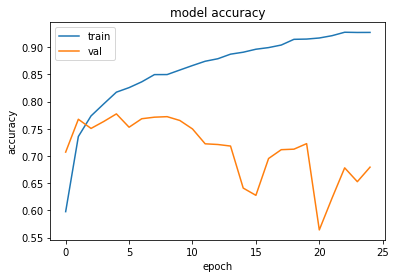

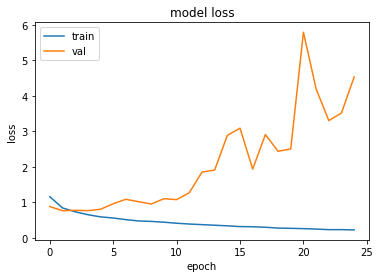

In [ ]:
PlotModel(history=history)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = data['Department Name'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(list(data['Lemmatisation_Review_str']), y, 
                                                   test_size=0.2, 
                                                   random_state = 0, 
                                                   #stratify = y,
                                                   shuffle=True)

In [ ]:
max_length = max(data['Lemmatisation_Review_str'].apply(lambda row : len(row)))
max_length

456

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_length)
vectorizer.adapt(X_train)

In [ ]:
import os 

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/drive/MyDrive/glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9196 words (1349 misses)


In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
genres = data['Department Name'].unique()

In [ ]:
from tensorflow.keras import layers, Input, Model

int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(embedded_sequences)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(5)(x)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_nlp = layers.Dense(len(genres), activation="softmax")(x)
                          
model_nlp = Model(int_sequences_input, output_nlp)
model_nlp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         3164100   
                                                                 
 batch_normalization (BatchN  (None, None, 300)        1200      
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                           

In [ ]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
model_nlp.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
history = model_nlp.fit(x_train, y_train,
                        batch_size=32, 
                        #callbacks=callback, 
                        epochs=25,
                        validation_split=0.2,
                        verbose=2)

Epoch 1/25
394/394 - 190s - loss: 1.1637 - acc: 0.5942 - val_loss: 0.7710 - val_acc: 0.7562 - 190s/epoch - 482ms/step
Epoch 2/25
394/394 - 195s - loss: 0.7719 - acc: 0.7660 - val_loss: 0.6711 - val_acc: 0.7896 - 195s/epoch - 494ms/step
Epoch 3/25
394/394 - 189s - loss: 0.6714 - acc: 0.7927 - val_loss: 0.6237 - val_acc: 0.7991 - 189s/epoch - 480ms/step
Epoch 4/25
394/394 - 190s - loss: 0.5966 - acc: 0.8141 - val_loss: 0.8294 - val_acc: 0.7219 - 190s/epoch - 482ms/step
Epoch 5/25
394/394 - 189s - loss: 0.5369 - acc: 0.8287 - val_loss: 0.7535 - val_acc: 0.7797 - 189s/epoch - 479ms/step
Epoch 6/25
394/394 - 189s - loss: 0.5094 - acc: 0.8415 - val_loss: 0.7823 - val_acc: 0.7664 - 189s/epoch - 481ms/step
Epoch 7/25
394/394 - 190s - loss: 0.4565 - acc: 0.8526 - val_loss: 1.1856 - val_acc: 0.6999 - 190s/epoch - 482ms/step
Epoch 8/25
394/394 - 189s - loss: 0.4339 - acc: 0.8603 - val_loss: 1.1914 - val_acc: 0.7069 - 189s/epoch - 480ms/step
Epoch 9/25
394/394 - 187s - loss: 0.4104 - acc: 0.8700 -

In [ ]:
def PlotModel(history=history, metric='acc', metric_val='val_acc', loss='loss',
              val_loss='val_loss'):  
  ### Graphique des résultats de l'entraînement ###
  plt.plot(history.history[metric])
  plt.plot(history.history[metric_val])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history[loss])
  plt.plot(history.history[val_loss])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

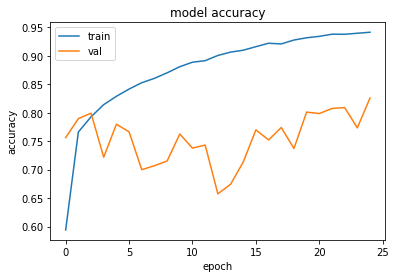

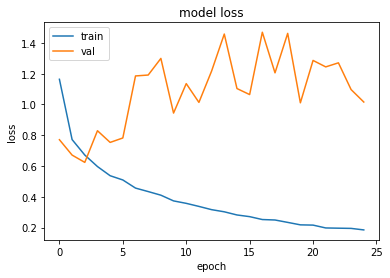

In [ ]:
PlotModel(history=history)